# Stellargraph example: Personalised Propagation of Neural Predictions (PPNP) and Approximate PPNP (APPNP) on the CORA citation dataset

Import NetworkX and stellar:

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer.ppnp import PPNP
from stellargraph.layer.appnp import APPNP

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

/Users/kieranricardo/anaconda3/envs/stellar-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kieranricardo/anaconda3/envs/stellar-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kieranricardo/anaconda3/envs/stellar-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/

### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz).

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = os.path.join("~", "DataSets", "cora")

Load the graph from edgelist (in the order `cited-paper` <- `citing-paper`)

In [3]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [7]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 1000 node labels for training, 500 for validation, and the rest for testing.

In [8]:
train_data, test_data = model_selection.train_test_split(
    node_data, train_size=1000, test_size=None, stratify=node_data['subject']
)
val_data, test_data = model_selection.train_test_split(
    test_data, train_size=500, test_size=None, stratify=test_data['subject']
)

Note using stratified sampling gives the following counts:

In [9]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Reinforcement_Learning': 80,
         'Genetic_Algorithms': 154,
         'Theory': 130,
         'Rule_Learning': 67,
         'Case_Based': 110,
         'Neural_Networks': 302,
         'Probabilistic_Methods': 157})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [10]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [11]:
node_features = node_data[feature_names]

## Creating the PPNP model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [12]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [13]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



To feed data from the graph to the Keras model we need a generator. Since PPNP is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and the normalized graph Laplacian matrix to the model.

Specifying the `method='gcn'` argument to the `FullBatchNodeGenerator` will pre-process the adjacency matrix and supply the normalized graph Laplacian matrix to the model.

In [14]:
generator = FullBatchNodeGenerator(G, method="ppnp", sparse=False)

/Users/kieranricardo/anaconda3/envs/stellar-env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/kieranricardo/anaconda3/envs/stellar-env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


For training we map only the training nodes returned from our splitter and the target values.

In [15]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each full fully connected layer in the model. In this example we use three fully connected layers with 64,64, and 7 hidden node features at each layer. 
 * `activations` is a list of activations applied to each layer's output
 * `dropout=0.5` specifies a 50% dropout at each layer. 
 
 #### Note that the size of the final fully connected layer must be equal to the number of classes you are trying to predict.


We create a PPNP model as follows:

In [16]:
ppnp = PPNP([64, 64, train_targets.shape[-1]], ['relu', 'relu', 'relu'], 
             generator, transport_probability=0.1, 
              dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))

x_inp, x_out = ppnp.node_model()
predictions = keras.layers.Softmax()(x_out)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer

In [17]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [18]:
val_gen = generator.flow(val_data.index, val_targets)

Create callbacks for early stopping (if validation accuracy stops improving) and best model checkpoint saving:

In [19]:
if not os.path.isdir("logs"):
    os.makedirs("logs")

In [20]:
es_callback = EarlyStopping(monitor="val_acc", patience=50)  # patience is the number of epochs to wait before early stopping in case of no further improvement

mc_callback = ModelCheckpoint(
    "logs/best_ppnp_model.h5",
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
)

Train the model

In [21]:
history = model.fit_generator(
    train_gen,
    epochs=80,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/80
1/1 - 1s - loss: 2.1179 - acc: 0.2270 - val_loss: 2.0451 - val_acc: 0.3020
Epoch 2/80
1/1 - 0s - loss: 2.0419 - acc: 0.2690 - val_loss: 1.9692 - val_acc: 0.3020
Epoch 3/80
1/1 - 0s - loss: 1.9673 - acc: 0.3090 - val_loss: 1.9042 - val_acc: 0.3020
Epoch 4/80
1/1 - 0s - loss: 1.9384 - acc: 0.2960 - val_loss: 1.8373 - val_acc: 0.3040
Epoch 5/80
1/1 - 0s - loss: 1.8722 - acc: 0.2960 - val_loss: 1.7776 - val_acc: 0.4040
Epoch 6/80
1/1 - 0s - loss: 1.8265 - acc: 0.3580 - val_loss: 1.7210 - val_acc: 0.4920
Epoch 7/80
1/1 - 0s - loss: 1.7963 - acc: 0.3930 - val_loss: 1.6471 - val_acc: 0.5940
Epoch 8/80
1/1 - 0s - loss: 1.7080 - acc: 0.4490 - val_loss: 1.5453 - val_acc: 0.6340
Epoch 9/80
1/1 - 0s - loss: 1.6592 - acc: 0.4780 - val_loss: 1.4351 - val_acc: 0.6560
Epoch 10/80
1/1 - 0s - loss: 1.5579 - acc: 0.5300 - val_loss: 1.3306 - val_acc: 0.6640
Epoch 11/80
1/1 - 0s - loss: 1.5153 - acc: 0.5370 - val_loss: 1.2419 - val_acc: 0.6800
Epoch 12/80
1/1 - 0s - loss: 1.4467 - acc: 0.5900 - 

Plot the training history:

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

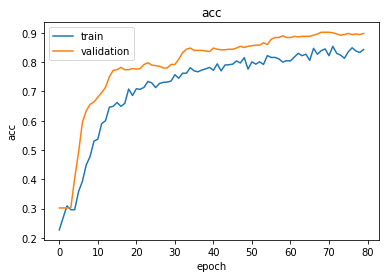

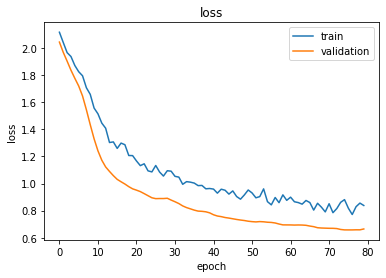

In [23]:
plot_history(history)

Reload the saved weights of the best model found during the training (according to validation accuracy)

In [24]:
model.load_weights("logs/best_ppnp_model.h5")

Evaluate the best model on the test set

In [25]:
test_gen = generator.flow(test_data.index, test_targets)

In [26]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.7691
	acc: 0.8642


## Using the Approximate PPNP Model

Lets repeat the training and testing steps with the APPNP model using the same dataset. The downside of the PPNP is that you have to invert the adjacency matrix - which is time inneficient for large graphs - and store that invert matrix - which is space innefficient! The approximate model avoids this issue by using a clever mathematical trick.

In [27]:
generator = FullBatchNodeGenerator(G, method="gcn", sparse=True)

train_gen = generator.flow(train_data.index, train_targets)
val_gen = generator.flow(val_data.index, val_targets)
test_gen = generator.flow(test_data.index, test_targets)

appnp = APPNP([64, 64, train_targets.shape[-1]], ['relu', 'relu', 'relu'], 
             generator, transport_probability=0.1, 
              dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))

x_inp, x_out = appnp.node_model()
predictions = keras.layers.Softmax()(x_out)

model = keras.models.Model(inputs=x_inp, outputs=predictions)
model.compile(loss='categorical_crossentropy', metrics=['acc'],
                  optimizer=keras.optimizers.Adam(lr=0.01))

es_callback = EarlyStopping(monitor="val_acc", patience=50)  # patience is the number of epochs to wait before early stopping in case of no further improvement

mc_callback = ModelCheckpoint(
    "logs/best_appnp_model.h5",
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit_generator(
    train_gen,
    epochs=120,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Using GCN (local pooling) filters...


Epoch 1/120
1/1 - 1s - loss: 2.4944 - acc: 0.1240 - val_loss: 2.0931 - val_acc: 0.1680
Epoch 2/120
1/1 - 0s - loss: 2.1512 - acc: 0.2090 - val_loss: 1.9981 - val_acc: 0.3020
Epoch 3/120
1/1 - 0s - loss: 2.1420 - acc: 0.2970 - val_loss: 1.8701 - val_acc: 0.4640
Epoch 4/120
1/1 - 0s - loss: 1.8490 - acc: 0.4150 - val_loss: 1.9160 - val_acc: 0.5280
Epoch 5/120
1/1 - 0s - loss: 1.8896 - acc: 0.4010 - val_loss: 1.8810 - val_acc: 0.5640
Epoch 6/120
1/1 - 0s - loss: 1.8191 - acc: 0.4480 - val_loss: 1.7760 - val_acc: 0.6340
Epoch 7/120
1/1 - 0s - loss: 1.7135 - acc: 0.5170 - val_loss: 1.5878 - val_acc: 0.7140
Epoch 8/120
1/1 - 0s - loss: 1.5417 - acc: 0.6290 - val_loss: 1.3680 - val_acc: 0.7500
Epoch 9/120
1/1 - 0s - loss: 1.4016 - acc: 0.6450 - val_loss: 1.1834 - val_acc: 0.7620
Epoch 10/120
1/1 - 0s - loss: 1.3020 - acc: 0.6740 - val_loss: 1.0727 - val_acc: 0.7580
Epoch 11/120
1/1 - 0s - loss: 1.2448 - acc: 0.6850 - val_loss: 1.0248 - val_acc: 0.7700
Epoch 12/120
1/1 - 0s - loss: 1.1932 - ac

Epoch 64/120
1/1 - 0s - loss: 0.3876 - acc: 0.9450 - val_loss: 0.6552 - val_acc: 0.8720
Epoch 65/120
1/1 - 0s - loss: 0.4359 - acc: 0.9340 - val_loss: 0.6499 - val_acc: 0.8720
Epoch 66/120
1/1 - 0s - loss: 0.4460 - acc: 0.9260 - val_loss: 0.6505 - val_acc: 0.8780
Epoch 67/120
1/1 - 0s - loss: 0.4183 - acc: 0.9420 - val_loss: 0.6592 - val_acc: 0.8820
Epoch 68/120
1/1 - 0s - loss: 0.4177 - acc: 0.9410 - val_loss: 0.6602 - val_acc: 0.8800
Epoch 69/120
1/1 - 0s - loss: 0.4186 - acc: 0.9360 - val_loss: 0.6620 - val_acc: 0.8680
Epoch 70/120
1/1 - 0s - loss: 0.3991 - acc: 0.9350 - val_loss: 0.6687 - val_acc: 0.8640
Epoch 71/120
1/1 - 0s - loss: 0.3794 - acc: 0.9470 - val_loss: 0.6664 - val_acc: 0.8700
Epoch 72/120
1/1 - 0s - loss: 0.4280 - acc: 0.9260 - val_loss: 0.6626 - val_acc: 0.8700
Epoch 73/120
1/1 - 0s - loss: 0.3826 - acc: 0.9490 - val_loss: 0.6708 - val_acc: 0.8780
Epoch 74/120
1/1 - 0s - loss: 0.3915 - acc: 0.9460 - val_loss: 0.6807 - val_acc: 0.8840
Epoch 75/120
1/1 - 0s - loss: 0.

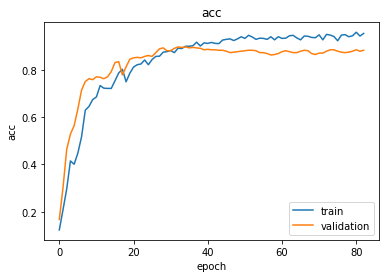

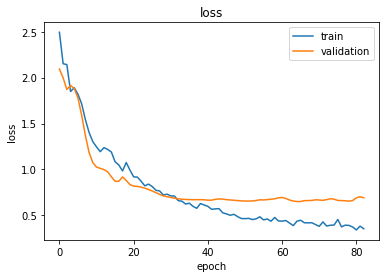

In [28]:
plot_history(history)

In [29]:
model.load_weights("logs/best_appnp_model.h5")
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.8001
	acc: 0.8444


### Super Scalable Training

No we're going exploit the unique structure of PPNP for super scalable training! PPNP consists of a fully-connected neural network followed by a graph propogation step. For each node, the fully-connected network outputs a score for each class and the propogaiton step basically takes a weighted average of scores of nearby nodes (closer nodes are weighted higher). 

Above, we trained the whole network end-to-end which gets the most accurate results but this requires us to load the entire graph onto our GPU memory because we need the entire graph for the propogation step. For exascale graphs too large to fit onto a single GPUs memory this just isn't going to cut it. But, we can get around this by JUST training the fully connected network and then propogate the trained fully connected network instead of training the whole network end-to-end. The advantage of this is that we can distribute the training across as many GPUs as we like and handle abritrarily large graphs. Then we can do our final predictions with graph propogation on CPU! 

The model in the propagation step can be ANY keras model trained on node features to predict the targets. In this example we use a fully connected neural network with bag of word features as input. We could easily swap out the bag of words features for the complete text and swap out the fully connected network for a state-of-the-art BERT model, fine-tune the BERT model and propagate its predictions!

First we create and train a fully connected model.

In [30]:
model = keras.models.Model()

in_layer = layers.Input(shape=(len(feature_names),))
layer = layers.Dense(64, activation='relu', kernel_regularizer="l2")(in_layer)
layer = layers.Dropout(0.5)(layer)
layer = layers.Dense(64, activation='relu', kernel_regularizer="l2")(in_layer)
layer = layers.Dropout(0.5)(layer)

#note the dimension of the output should equal the number of classes to predict!
layer = layers.Dense(train_targets.shape[-1], activation='relu')(layer)
layer = layers.Dropout(0.5)(layer)
layer = layers.Softmax()(layer)

fully_connected_model = keras.models.Model(inputs=in_layer, outputs=layer)

fully_connected_model.compile(loss='categorical_crossentropy', metrics=['acc'],
                  optimizer=keras.optimizers.Adam(lr=0.01))

#the inputs are just the node features
X_train = train_data[feature_names].values.astype(np.float32)
X_val = val_data[feature_names].values.astype(np.float32)

In [32]:
es_callback = EarlyStopping(monitor="val_acc", patience=50)  # patience is the number of epochs to wait before early stopping in case of no further improvement

mc_callback = ModelCheckpoint(
    "logs/best_fc_model.h5",
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
)

history = fully_connected_model.fit(X_train, train_targets, 
                          validation_data=(X_val, val_targets), 
                          epochs=2000, batch_size=200, shuffle=True, #we can shuffle the data here as 
                         callbacks=[es_callback, mc_callback]) #we're only working with node features

Train on 1000 samples, validate on 500 samples
Epoch 1/2000
1000/1000 [==============================] - 0s 224us/sample - loss: 2.5818 - acc: 0.1870 - val_loss: 2.0615 - val_acc: 0.3500
Epoch 2/2000
1000/1000 [==============================] - 0s 29us/sample - loss: 2.0255 - acc: 0.3030 - val_loss: 1.9426 - val_acc: 0.5680
Epoch 3/2000
1000/1000 [==============================] - 0s 30us/sample - loss: 1.9788 - acc: 0.3490 - val_loss: 1.7979 - val_acc: 0.6660
Epoch 4/2000
1000/1000 [==============================] - 0s 34us/sample - loss: 1.8088 - acc: 0.4130 - val_loss: 1.6738 - val_acc: 0.6820
Epoch 5/2000
1000/1000 [==============================] - 0s 32us/sample - loss: 1.7327 - acc: 0.4520 - val_loss: 1.6268 - val_acc: 0.7000
Epoch 6/2000
1000/1000 [==============================] - 0s 31us/sample - loss: 1.7279 - acc: 0.4440 - val_loss: 1.6093 - val_acc: 0.7260
Epoch 7/2000
1000/1000 [==============================] - 0s 24us/sample - loss: 1.6755 - acc: 0.4790 - val_loss: 1.58

1000/1000 [==============================] - 0s 23us/sample - loss: 1.7237 - acc: 0.5030 - val_loss: 1.6149 - val_acc: 0.7080
Epoch 60/2000
1000/1000 [==============================] - 0s 21us/sample - loss: 1.7464 - acc: 0.4840 - val_loss: 1.6264 - val_acc: 0.7300
Epoch 61/2000
1000/1000 [==============================] - 0s 20us/sample - loss: 1.7130 - acc: 0.5090 - val_loss: 1.6226 - val_acc: 0.7340
Epoch 62/2000
1000/1000 [==============================] - 0s 22us/sample - loss: 1.7854 - acc: 0.4710 - val_loss: 1.5903 - val_acc: 0.7480
Epoch 63/2000
1000/1000 [==============================] - 0s 21us/sample - loss: 1.7492 - acc: 0.4890 - val_loss: 1.5732 - val_acc: 0.7200
Epoch 64/2000
1000/1000 [==============================] - 0s 22us/sample - loss: 1.8121 - acc: 0.4620 - val_loss: 1.5865 - val_acc: 0.7300
Epoch 65/2000
1000/1000 [==============================] - 0s 26us/sample - loss: 1.7795 - acc: 0.4700 - val_loss: 1.6161 - val_acc: 0.7180
Epoch 66/2000
1000/1000 [=========

By itself the fully connected model only gets ~60-70% accuracy on the test set.

In [33]:
X_test = test_data[feature_names].values.astype(np.float32)

fully_connected_model.load_weights("logs/best_fc_model.h5") 
test_metrics = fully_connected_model.evaluate(X_test, test_targets)
print("\nTest Set Metrics:")
for name, val in zip(fully_connected_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1208/1208 [==============================] - 0s 21us/sample - loss: 1.5839 - acc: 0.7136

Test Set Metrics:
	loss: 1.5839
	acc: 0.7136


Now we propogate the fully connected network - no extra training required and we can re-use the APPNP object we've already created.

In [34]:
x_inp, x_out = appnp.propagate_model(fully_connected_model)
predictions = keras.layers.Softmax()(x_out)

model = keras.models.Model(inputs=x_inp, outputs=predictions)
model.compile(loss='categorical_crossentropy', metrics=['acc'],
                  optimizer=keras.optimizers.Adam(lr=0.01))

Our accuracy is almost as good as end-to-end trained PPNP and APPNP but now we can handle abitrarily large graphs! 

In [35]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 1.0768
	acc: 0.8593


### Making predictions with the model

Now let's get the predictions for all nodes.

In [36]:
all_nodes = node_data.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_gen)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories.

Note that for full-batch methods the batch size is 1 and the predictions have shape $(1, N_{nodes}, N_{classes})$ so we remove the batch dimension to obtain predictions of shape $(N_{nodes}, N_{classes})$ using the NumPy `squeeze` method.

In [37]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

Let's have a look at a few predictions after training the model:

In [38]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data['subject']})
df.head(20)

,Predicted,True
31336,subject=Neural_Networks,Neural_Networks
1061127,subject=Rule_Learning,Rule_Learning
1106406,subject=Reinforcement_Learning,Reinforcement_Learning
13195,subject=Reinforcement_Learning,Reinforcement_Learning
37879,subject=Probabilistic_Methods,Probabilistic_Methods
1126012,subject=Probabilistic_Methods,Probabilistic_Methods
1107140,subject=Reinforcement_Learning,Theory
1102850,subject=Neural_Networks,Neural_Networks
31349,subject=Neural_Networks,Neural_Networks
1106418,subject=Theory,Theory


Now we have an accurate model that can handle abritrarily large graphs and be trained accross as many GPU clusters as we need!